In [18]:
using Plots, DifferentialEquations, Interpolations, Distributions, NLopt, SimpleDiffEq, Dierckx, LinearAlgebra, LaTeXStrings, ForwardDiff,LinearAlgebra,Roots
gr(); #Load packages

In [5]:
function diff!(du,u,p,t)  #method-of-lines discretisation of the surrogate PDE model
dx,N,D,λ=p 
for i in 2:N-1
du[i]=(D*(u[i-1]-2*u[i]+u[i+1])/dx^2+λ*u[i]*(1-u[i])) 
end
du[1]=(D*(u[2]-u[1])/dx^2+λ*u[1]*(1-u[1])) 
du[N]=(D*(u[N-1]-u[N])/dx^2+λ*u[N]*(1-u[N])) 
end

diff! (generic function with 1 method)

In [6]:
function pdesolver(L,dx,N,T,ic,D,λ)  #method-of-lines discretisation of the surrogate PDE model
p=(dx,N,D,λ)
tspan=(0.0,maximum(T))
prob=ODEProblem(diff!,ic,tspan,p)
alg=Heun()
sol=solve(prob,alg,saveat=T);
return sol
end

pdesolver (generic function with 1 method)

In [7]:
function Optimise(fun,θ₀,lb,ub) #NLopt routine
    tomax=(θ,∂θ)->fun(θ)
    opt=Opt(:LN_BOBYQA,length(θ₀))
    opt.max_objective=tomax
    opt.lower_bounds=lb      
    opt.upper_bounds=ub
    opt.maxtime=1*60
    res = optimize(opt,θ₀)
    return res[[2,1]]
end

Optimise (generic function with 1 method)

In [8]:
L=1900; #Physical problem definitions
T=[0,48];
dx=5.0;
N=Int(round(L/dx))+1;
D=1000; #Estimate of diffusivity in microns squared per hour
λ=0.067; #Estimate of growth rate in per hour

numsol=zeros(N,2);
ic=zeros(N);
data=zeros(38,2);
count=zeros(38,2);

xlocdata =[25,75,125,175,225,275,325,375,425,475,525,575,625,675,725,775,825,875,925,975,1025,1075,1125,1175,1225,1275,1325,1375,1425,1475,1525,1575,1625,1675,1725,1775,1825,1875];
count[:,1]=[89  78  87  79  79  79  84  82  85  74  71  43  6  3  2  1  2  1  2  2  3  1  2  2  1  1  2  5  41  82  79  77  94  76  79  79  88  74];
count[:,2]=[127  125  122  120  122  119  119  112  109  107  110  102  97  99  94  94  93  101  93  94  86  101  94  91  98  99  97  96  103  107  106  104  119  114  124  122  124  120];
count=round.(Int,count./2.10) #Factor of two here associated with the column width - could be difference and we can explore..
data=count/60; #Maximum packing density of cells diameter 24 microns in a column of height 1430

In [10]:
interpr = linear_interpolation(xlocdata,data[:,1]); #Interpolate data at t=0 hours

for i in 1:N
xx = (i-1)*dx
    if xx >= 25 && xx <= 1875
    ic[i] = interpr(xx)
    elseif xx < 25
    ic[i] = data[1,1]
    elseif xx > 1875
    ic[i] = data[end,1]
    end
end

@time numsol=pdesolver(L,dx,N,T,ic,D,λ); #Solve the surrogate PDE model with parameter estimates

  0.009978 seconds (163 allocations: 48.469 KiB)


In [11]:
function loglhood(count,ic,a) #loglikelihood function
numsol=pdesolver(L,dx,N,T,ic,a[1],a[2]) 
u48 = linear_interpolation(0:dx:L,numsol[:,2]);
e=0
for ii in 1:size(count)[1]
e+=log(u48(xlocdata[ii])^count[ii,2]*(1-u48(xlocdata[ii]))^(max(60-count[ii,2],0)))
end
    return e
end

loglhood (generic function with 1 method)

In [12]:
a=zeros(2)
function funmle(a) #Loglikelihood function for NLOpt
return loglhood(count,ic,a)
end

funmle (generic function with 1 method)

  7.136074 seconds (3.34 M allocations: 185.447 MiB, 1.40% gc time, 58.42% compilation time)


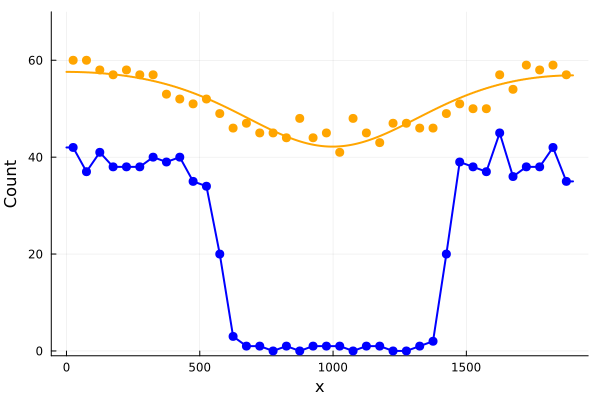

In [14]:
θG=[1000,0.05]
lb=[100, 0.001]
ub=[10000,1.00]
@time (xopt,fopt)=Optimise(funmle,θG,lb,ub)
fmle=fopt
Dmle=xopt[1]; 
λmle=xopt[2];

numsolb=pdesolver(L,dx,N,T,ic,Dmle,λmle); 
p1 = scatter(xlocdata,count[:,1],legend=false,msw=0,ms=5,color=:blue,msa=:blue,ylims=(-1,70))
p1 = plot!(0:dx:L,60*numsolb[:,1],lw=2,legend=false,color=:blue,ylims=(-1,70))
p1 = scatter!(xlocdata,count[:,2],legend=false,msw=0,ms=5,color=:orange,msa=:orange,ylims=(-1,70))
p1 = plot!(0:dx:L,60*numsolb[:,2],lw=2,legend=false,color=:orange,ylims=(-1.0,70),xlabel="x",ylabel="Count") 
#Superimpose MLE solution on data as a visual check 

In [15]:
xopt #Print out MLE

2-element Vector{Float64}:
 1287.1717769035265
    0.06212760837210805

In [20]:
fff(θ1,θ2) = funmle([θ1,θ2]) #Compute the observed Fisher Information at the MLE
H = -ForwardDiff.hessian(z -> fff(z[1],z[2]),xopt);
H = Symmetric(H)

2×2 Symmetric{Float64, Matrix{Float64}}:
  0.109313  18.3235
 18.3235     4.45871e5

In [21]:
Σ = inv(H);
mvnorm = MvNormal(xopt, Σ); #MVN distribution to invoke Laplace's approximation
M=1000
samples = rand(mvnorm, M); #Draw parameter samples

In [22]:
Dsampled=samples[1,:];
λsampled=samples[2,:];

In [23]:
xx = 0:dx:L
lower=1000*ones(length(xx))
upper=zeros(length(xx))

for i in 1:M
numsol=pdesolver(L,dx,N,T,ic,Dsampled[i],λsampled[i]);

p48 = linear_interpolation(0:dx:L,numsol[:,2]);

    for j in 1:length(xx)

        if (quantile(Binomial(60,p48(xx[j])),[.05,.95])[1]) < lower[j] 
            lower[j] = (quantile(Binomial(60,p48(xx[j])),[.05,.95])[1])
        end

        if (quantile(Binomial(60,p48(xx[j])),[.05,.95])[2]) > upper[j] 
            upper[j] = (quantile(Binomial(60,p48(xx[j])),[.05,.95])[2])
        end
    end

end


numsol=pdesolver(L,dx,N,T,ic,Dmle,λmle); 

Index: 200
Index: 400
Index: 600
Index: 800
Index: 1000


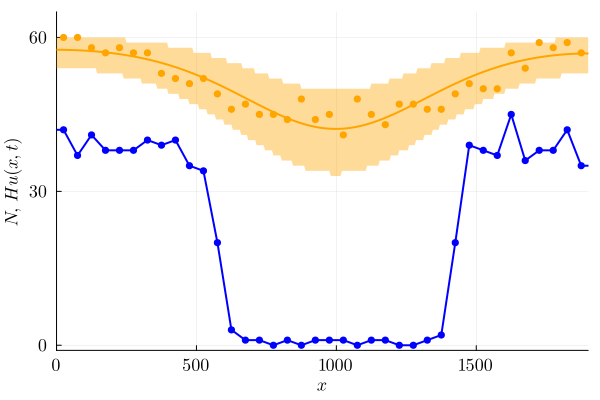

In [24]:
p2 = scatter(xlocdata,count[:,1],mc=:blue,msc=:auto,label=false)
p2 = plot!(0:dx:L,60*numsolb[:,1],lw=2,legend=false,color=:blue,label=false)
p2 = scatter!(xlocdata,count[:,2],color=:orange,msc=:auto,label=false)
p2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
p2 = plot!(0:dx:L,60*numsolb[:,2],lw=2,legend=false,color=:orange,ylims=(-1.0,65),xlabel=L"x",ylabel=L"N, \, H u(x,t)")
p2=plot!(xticks=([0, 500, 1000, 1500],[L"0", L"500", L"1000", L"1500"]))
p2=plot!(yticks=([0, 30, 60],[L"0",L"30",L"60"]),xlims=(0,1900),ylims=(-1,65))
p2=plot!(xx,lower,lw=0,fillrange=upper,fillalpha=0.40,color=:orange,label=false)
display(p2) #Figure 13(c)
#savefig(p2,"Scratch.pdf")

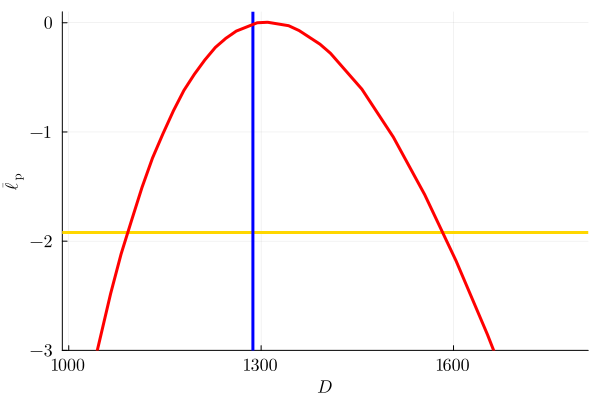

In [25]:
df=1
llstar=-quantile(Chisq(df),0.95)/2;
function univariateD(D) #Compute profile likelihood for D
    a=zeros(1)    
    function funD(a)
    return loglhood(count,ic,[D,a[1]])
    end
    θG=[λmle]
    lb=[0.01] 
    ub=[0.50] 
    (xopt,fopt)=Optimise(funD,θG,lb,ub)
    return fopt,xopt
    end 
    fb(x) = univariateD(x)[1]


#Take a grid of M points to plot the univariate profile likelihood
M=50;
Drange=LinRange(1000,1800,M)
ff=zeros(M)
for i in 1:M
    ff[i]=univariateD(Drange[i])[1]
    #println(i)
end

q1=hline([llstar],legend=false,lw=3,color=:gold)
q1=vline!([Dmle],legend=false,xlabel=L"D",ylabel=L"\bar{\ell}_{\textrm{p}}",lw=3,color=:blue)
spl=Spline1D(Drange,ff.-maximum(ff),w=ones(length(Drange)),k=1,bc="nearest",s=1/1000)
yy=evaluate(spl,Drange)
q1=plot!(Drange,yy,lw=3,lc=:red,ylims=(-3,0.1),xlims=(Drange[1]-10,Drange[end]+10))
q1=plot!(xticks=([1000,1300,1600],[L"1000",L"1300", L"1600"]))
q1=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]))
q1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(q1)

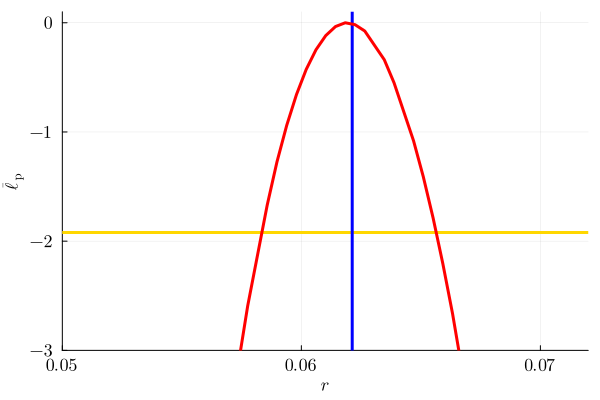

In [26]:
function univariateλ(λ) #Compute profile likelihood for r
a=zeros(1)    
function funλ(a)
return loglhood(count,ic,[a[1],λ])
end
θG=[Dmle]
lb=[500] 
ub=[3000] 
(xopt,fopt)=Optimise(funλ,θG,lb,ub)
return fopt,xopt
end 
f(x) = univariateλ(x)[1]

    #Take a grid of M points to plot the univariate profile likelihood

λrange=LinRange(0.05,0.07,M)
ff=zeros(M)

for i in 1:M
ff[i]=univariateλ(λrange[i])[1]       
#println(i)
end
    
q2=hline([llstar],legend=false,lw=3,color=:gold)
q2=vline!([λmle],legend=false,xlabel=L"r",ylabel=L"\bar{\ell}_{\textrm{p}}",lw=3,color=:blue)
spl=Spline1D(λrange,ff.-maximum(ff),w=ones(length(λrange)),k=1,bc="nearest",s=1/1000)
yy=evaluate(spl,λrange)
q2=plot!(λrange,yy,lw=3,lc=:red,ylims=(-3,0.1),xlims=(λrange[1],λrange[end]+0.002))
q2=plot!(xticks=([0.05,0.06,0.07],[L"0.05",L"0.06", L"0.07"]))
q2=plot!(yticks=([0,-1,-2,-3],[L"0", L"-1", L"-2", L"-3"]))
q2=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
display(q2)

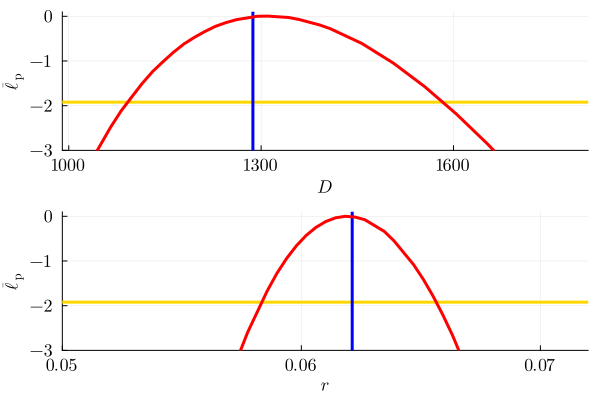

In [27]:
q3=plot(q1,q2,layout=(2,1))
display(q3) #Figure 13(d)-(e)